## Evaluation of Unsupervised Model on Real Benign and Attack Traffic

This notebook evaluates the aggressively tuned Isolation Forest model on real-world traffic. It begins by loading the model, scaler, and threshold information. Benign-only files are used to assess the false positive rate, followed by labeled benign and attack samples to compute classification metrics and visualize the confusion matrix. Despite threshold tuning, the model shows excessive sensitivity, leading to a strategic shift away from unsupervised methods toward supervised learning.


In [9]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Model & Feature Setup

This section defines all paths and loads the necessary components to perform inference on new data. It loads the previously saved Isolation Forest model, the corresponding scaler, and the threshold metadata. It also loads a reference dataset to extract and enforce the expected feature list for consistency in evaluation.

In [10]:
model_path = '../../models/3_aggressive_tuned/iforest_aggressive.joblib'
scaler_path = '../../models/1_first_model/scaler.joblib'
threshold_path = '../../models/3_aggressive_tuned/threshold_info.joblib'
benign_folder = '../../real_data/benign' 
attack_folder = '../../real_data/attack'
reference_csv = '../../data/cleaned_cic.csv'  # Used to infer expected features

In [11]:
print("Loading model, scaler, and threshold...")
model = joblib.load(model_path)
scaler = joblib.load(scaler_path)
threshold = joblib.load(threshold_path)
print(f"Threshold loaded: {threshold}")

print(f"Loading reference feature list from: {reference_csv}")
ref_df = pd.read_csv(reference_csv)
expected_features = ref_df.select_dtypes(include=[np.number]).drop(columns=['attack']).columns.tolist()
print(f"Loaded {len(expected_features)} numeric features")


Loading model, scaler, and threshold...
Threshold loaded: {'threshold': 0.10843373493975904, 'params': {'bootstrap': False, 'contamination': 0.01, 'max_features': 1.0, 'max_samples': 0.8, 'n_estimators': 100, 'n_jobs': None, 'random_state': 42, 'verbose': 0, 'warm_start': False}, 'recall_attack': 0.8246681376177779, 'recall_benign': 0.7060546290262931, 'fpr': 0.29394537097370693, 'score': 0.6153613833220354}
Loading reference feature list from: ../../data/cleaned_cic.csv
Loaded 77 numeric features


## 2. Benign Evaluation and False Positive Count

This block tests the tuned model on all benign-only CSVs. Each file is checked for feature conformity, scaled, and passed through the model. Predictions are made using the loaded threshold. For each file, the number of false positives (benign samples incorrectly flagged as attacks) is counted and accumulated. This helps quantify how noisy or sensitive the model is when exposed to strictly benign traffic.

In [12]:
# Ensure threshold is a float in case it's a dictionary
if isinstance(threshold, dict):
    threshold = threshold.get("best_threshold", list(threshold.values())[0])

# Initialize counters
false_positives_total = 0
benign_samples_total = 0

# File to test
filename = 'synthetic_benign_1.csv'
path = os.path.join(benign_folder, filename)

# Load and prepare
df = pd.read_csv(path)
df_numeric = df.select_dtypes(include=[np.number])

if 'attack' in df_numeric.columns:
    df_numeric = df_numeric.drop(columns=['attack'])

# Check for feature mismatch
if not all(f in df_numeric.columns for f in expected_features):
    print(f"Skipping {filename}: missing required features.")
else:
    df_numeric = df_numeric[expected_features]

    # Scale and predict
    X_scaled = scaler.transform(df_numeric)
    scores = model.decision_function(X_scaled)
    preds = (scores < threshold).astype(int)  # 1 = predicted attack

    # Metrics for benign-only data
    false_positives = np.sum(preds == 1)
    true_negatives = np.sum(preds == 0)
    total = len(preds)
    recall_benign = true_negatives / total if total else 0
    fpr = false_positives / (false_positives + true_negatives) if (false_positives + true_negatives) else 0

    # Print detailed metrics
    print(f"\n=== Evaluation on {filename} ===")
    print(f"Total Samples: {total}")
    print(f"False Positives (Benign flagged as attack): {false_positives}")
    print(f"True Negatives (Correctly ignored): {true_negatives}")
    print(f"Recall (Benign): {recall_benign:.4f}")
    print(f"False Positive Rate: {fpr:.4f}")



=== Evaluation on synthetic_benign_1.csv ===
Total Samples: 223222
False Positives (Benign flagged as attack): 223222
True Negatives (Correctly ignored): 0
Recall (Benign): 0.0000
False Positive Rate: 1.0000


## 3. Score Distribution Visualization

A histogram is used to visualize the distribution of anomaly scores on benign-only data, with the selected threshold overlaid. This plot helps confirm whether the decision boundary effectively isolates outliers from the benign majority, and whether the threshold is too aggressive or too loose.

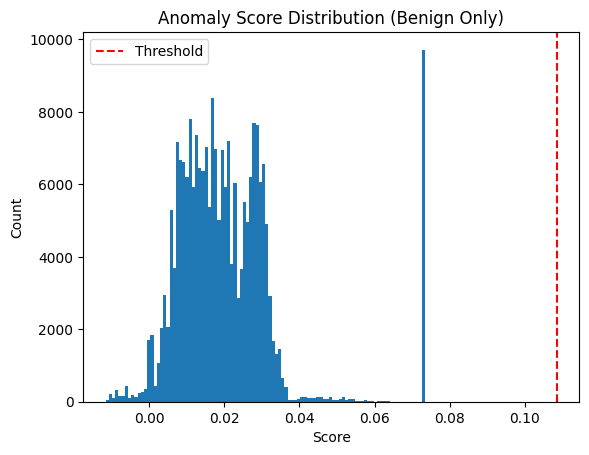

In [13]:
scores = model.decision_function(X_scaled)  # Get anomaly scores for each sample

plt.hist(scores, bins=100)
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Anomaly Score Distribution (Benign Only)")
plt.xlabel("Score")
plt.ylabel("Count")
plt.legend()
plt.show()

## 4. Mixed Data Evaluation (Benign + Attack)

This final evaluation step merges all labeled benign and attack CSVs for a realistic test scenario. After combining and scaling the data, predictions are made and performance metrics (precision, recall, F1-score) are calculated. A confusion matrix heatmap provides a clear visual of how the model distinguishes between classes under real-world conditions.

In [14]:
# Load and combine only the selected benign and attack files
print("\nLoading synthetic benign and attack samples...")

# Load specific benign file
benign_df = pd.read_csv(os.path.join(benign_folder, "synthetic_benign_1.csv"))

# Load specific attack file
attack_df = pd.read_csv(os.path.join(attack_folder, "synthetic_attack_1.csv"))

# Combine and filter
combined_df = pd.concat([benign_df, attack_df], ignore_index=True)
X = combined_df[expected_features]
y_true = combined_df['attack'].astype(int)

# Scale and predict
X_scaled = scaler.transform(X)
y_pred = (model.decision_function(X_scaled) < threshold).astype(int)



Loading synthetic benign and attack samples...


=== Evaluation Results ===
True Negatives (Benign correctly identified): 0
False Positives (Benign predicted as attack): 223222
False Negatives (Missed attacks): 55160
True Positives (Attacks detected): 500145
Total Samples: 778527

Overall Accuracy       : 0.6424
Precision              : 0.6914
Recall (Attack)        : 0.9007
Recall (Benign)        : 0.0000
False Positive Rate    : 1.0000
F1-Score               : 0.7823

=== Classification Report ===
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00    223222
      Attack       0.69      0.90      0.78    555305

    accuracy                           0.64    778527
   macro avg       0.35      0.45      0.39    778527
weighted avg       0.49      0.64      0.56    778527



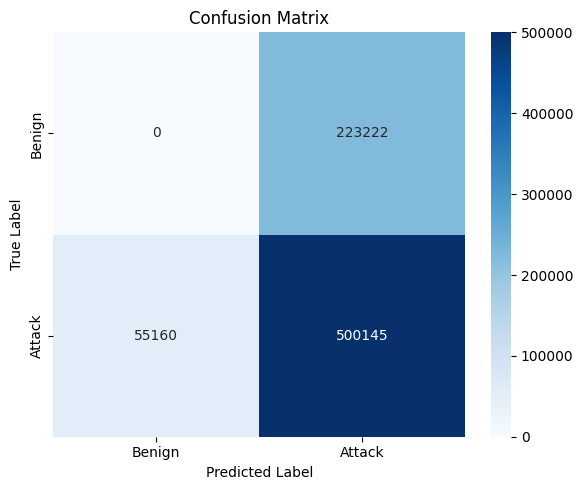

In [15]:
# Compute basic metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Compute class-wise recalls
recall_benign = tn / (tn + fp) if (tn + fp) > 0 else 0
recall_attack = tp / (tp + fn) if (tp + fn) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

# Print all key metrics
print("=== Evaluation Results ===")
print(f"True Negatives (Benign correctly identified): {tn}")
print(f"False Positives (Benign predicted as attack): {fp}")
print(f"False Negatives (Missed attacks): {fn}")
print(f"True Positives (Attacks detected): {tp}")
print(f"Total Samples: {len(y_true)}")
print()
print(f"Overall Accuracy       : {accuracy:.4f}")
print(f"Precision              : {precision:.4f}")
print(f"Recall (Attack)        : {recall_attack:.4f}")
print(f"Recall (Benign)        : {recall_benign:.4f}")
print(f"False Positive Rate    : {fpr:.4f}")
print(f"F1-Score               : {f1:.4f}")
print()
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=["Benign", "Attack"]))

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


## Model Rejection and Strategic Shift

The results obtained from the aggressively tuned Isolation Forest model demonstrate excessive sensitivity, particularly evident in the high false positive rate observed on benign-only traffic. Despite threshold optimization and multi-objective scoring strategies, the model consistently misclassifies benign flows, indicating a structural limitation in its unsupervised approach when applied to real, diverse traffic.

Given the project's objective—to develop an intrusion detection system that maintains high recall for attacks while keeping false positives low enough for real deployment—this behavior is unacceptable. Further tuning of the Isolation Forest has proven insufficient to meet these goals.

As a result, the project will shift focus to a supervised Random Forest classifier, trained on labeled real and synthetic traffic.